### 2022 Hackathon 401K Optimier 
Step 1.Data Scraping - Kevin Sun  
Step 2. Maching Learning - Caiwen Wu

In [130]:
#pip install seaborn

In [131]:
#pip install tensorflow

In [132]:
#pip install keras

In [133]:
#pip install yfinance -U

### Step1. Download the price history

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

from datetime import datetime
import time

#For Prediction
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

#For Optimization
import scipy.optimize as sco

In [6]:
import datetime
from dateutil.relativedelta import relativedelta

#end = datetime.date(2022,8,31)
end = datetime.datetime.now()
beg = end - relativedelta(years = 2)

In [7]:
# Setting the tickers and extracting the historical price data
blended_ticks = ["LINIX", "LIKIX", "STLFX", "LIZKX", "LIRIX", "LIBIX", "LIJIX", "LIVIX", "LIHIX", "LIWIX", "PIRMX", "PAUAX"] # blended fund investments
# BTC LPATH IDX 2030 N, 2040, 2050, 2060, RET, 2025, 2035, 2055, 2045, 2065, PIM INFL RESP MA IS, PIM ALL A ALL AUTH I
large_ticks1 = ["VRGWX", "VRVIX", "VSPVX"] # stock investments: large cap
# VANG RUS 1000 GR TR, 1000 VAL TR, VAN IS S&P500 IDX TR
large_ticks2 = ["FCNTX", "FDGRX"] # stock investments: large cap
# FID CONTRA POOL CL 3, FID GR CO POOL CL 3
mid_ticks =["ARTMX"] # stock investments: mid
# ARTISAN MID CAP
small_ticks1 =["VRTGX"] # stock investments: small
# VANG RUS 2000 GR TR
small_ticks2 =["SEVAX"] # stock investments: small
# SMID CAP VALUE ACCT
international_ticks = ["FIVLX", "FIGFX"] # stock investments: international
# INTL VALUE ACCOUNT, INTL GROWTH ACCOUNT
short_ticks = ["BTCFX"] # short term investments
# BTC SHRT-TERM INV
bond_ticks = ["PTTRX", "VBIPX"] # bond investments: income
# PIMCO TOAL RETURN, VANG ST BD IDX IS PL

blended_df = pd.DataFrame(yf.download(blended_ticks, start=beg, end=end)['Adj Close'])
large_df1 = pd.DataFrame(yf.download(large_ticks1, start=beg, end=end)['Adj Close'])
large_df2 = pd.DataFrame(yf.download(large_ticks2, start=beg, end=end)['Adj Close'])
mid_df = pd.DataFrame(yf.download(mid_ticks, start=beg, end=end)['Adj Close'], columns = ['ARTMX'])
small_df1 = pd.DataFrame(yf.download(small_ticks1, start=beg, end=end)['Adj Close'], columns = ['VRTGX'])
small_df2 = pd.DataFrame(yf.download(small_ticks2, start=beg, end=end)['Adj Close'], columns = ['SEVAX'])
international_df = pd.DataFrame(yf.download(international_ticks, start=beg, end=end)['Adj Close'])
short_df = pd.DataFrame(yf.download(short_ticks, start=beg, end=end)['Adj Close'], columns = ['BTCFX'])
bond_df = pd.DataFrame(yf.download(bond_ticks, start=beg, end=end)['Adj Close'])

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


In [8]:
dfall = pd.concat([blended_df, large_df1, large_df2, mid_df, small_df1, small_df2, international_df, short_df, bond_df], axis=1)
dfall.index = pd.to_datetime(dfall.index, format ='%Y-%m-%d')
#agg=df.resample('M').mean()
#agg.head()

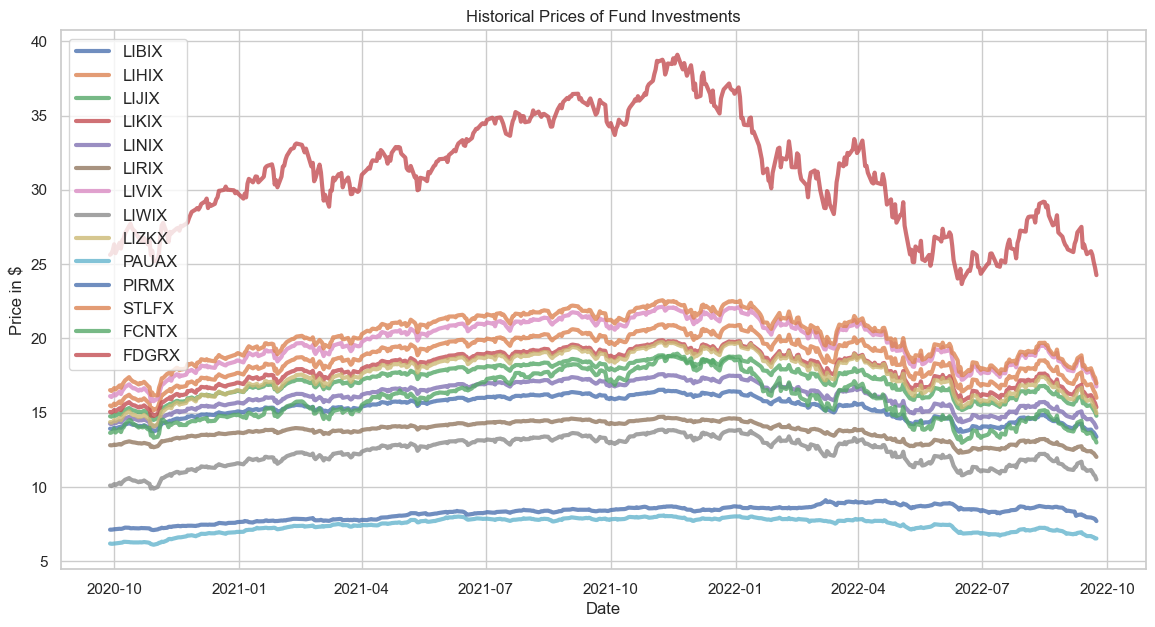

In [9]:
def generate_asset_plot(asset_dfs):
    df = pd.concat(asset_dfs, axis=1)
    plt.figure(figsize=(14, 7))
    for c in df.columns.values:
        plt.plot(df.index, df[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=12)
    plt.ylabel('Price in $')
    plt.xlabel('Date')
    plt.title('Historical Prices of Fund Investments')

generate_asset_plot([blended_df, large_df2])
#generate_asset_plot([large_df1, small_df1])
#generate_asset_plot([mid_df, small_df2, international_df, short_df])
#generate_asset_plot([bond_df])

### Step2. Train the model and forecast

In [10]:
def fund_pred(data,fundname,n_lookback,n_forecast,agg=False):
    # 0. Aggregate data if needed
    if agg:
        df=data.resample('W').mean()
    else: 
        df=data
    
    # 1. Scale/Normalize the data to make all values between 0 and 1
    dataset = df[fundname].fillna(method='bfill').values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # 2. Creating training data size : 70% of the data
    training_data_len = math.ceil(len(df) *.7)
    train_data = scaled_data[0:training_data_len , : ]

    # 3. Separating the data into x and y data
    x_train_data =[]
    y_train_data =[]
    for i in range(n_lookback,len(train_data)-n_forecast+1):
        x_train_data=list(x_train_data)
        y_train_data=list(y_train_data)
        x_train_data.append(train_data[i-n_lookback:i,0])
        y_train_data.append(train_data[i:i+n_forecast,0])
 
    # 4. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 5. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

    #6. Build the Long Short Term Memory (LSTM) model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=n_forecast)) 

    #7. Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

    #8. Testing the model on testing data
    # 1). Creating a dataset for testing
    test_data = scaled_data[training_data_len-n_lookback-n_forecast+1:, : ]
    x_test = []
    y_test = dataset[training_data_len:, : ]
    
    for i in range(n_lookback,len(test_data)-n_forecast+1):
        x_test.append(test_data[i-n_lookback:i,0])
    # 2).  Convert the values into arrays for easier computation
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    # 3). Making predictions on the testing data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # 4). Error calculation 
    rmse=np.sqrt(np.mean(((predictions[:,-1]- y_test)**2)))
    print('rmse for ',fundname,' is ',rmse)

    #9. Make Predictions
    train = df[:training_data_len]
    valid = df[training_data_len:]
    
    valid.loc[:,'Predictions'] = predictions[:,-1]

    # generate the forecasts
    X_ = scaled_data[- n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    # organize the results in a data frame
    df_past = df[fundname].reset_index()
    df_past.rename(columns={'index': 'Date', fundname: 'Actual'}, inplace=True)
    df_past['Date'] = pd.to_datetime(df_past['Date'])
    df_past['Forecast'] = np.nan
    df_past.loc[:,'Forecast'].iloc[-1] = df_past.loc[:,'Actual'].iloc[-1]
 
    df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
    if agg:
        df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=7), periods=n_forecast, freq = 'W')
    else:
        df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast, freq = 'B')
    df_future['Forecast'] = Y_.flatten()
    df_future['Actual'] = np.nan

    results = df_past.append(df_future).set_index('Date')
    results['Name'] = fundname
    
    # plot the results
    plt.figure(figsize=(16, 8))

    plt.plot(results['Forecast'],label='Forecast')

    plt.title('Fund:' + fundname)
    plt.xlabel('Date')
    plt.ylabel('Close')
    
    plt.plot(train[fundname],label='Train')
    plt.plot(valid[[fundname, 'Predictions']],label=['Val','Predictions'])
    plt.legend(loc='lower right')
    plt.show()
    return results

5/5 [==============================] - 1s 11ms/step
rmse for  LIBIX  is  0.8105303364545772
1/1 [==============================] - 0s 20ms/step


C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Predictions'] = predictions[:,-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.loc[:,'Forecast'].iloc[-1] = df_past.loc[:,'Actual'].iloc[-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.app

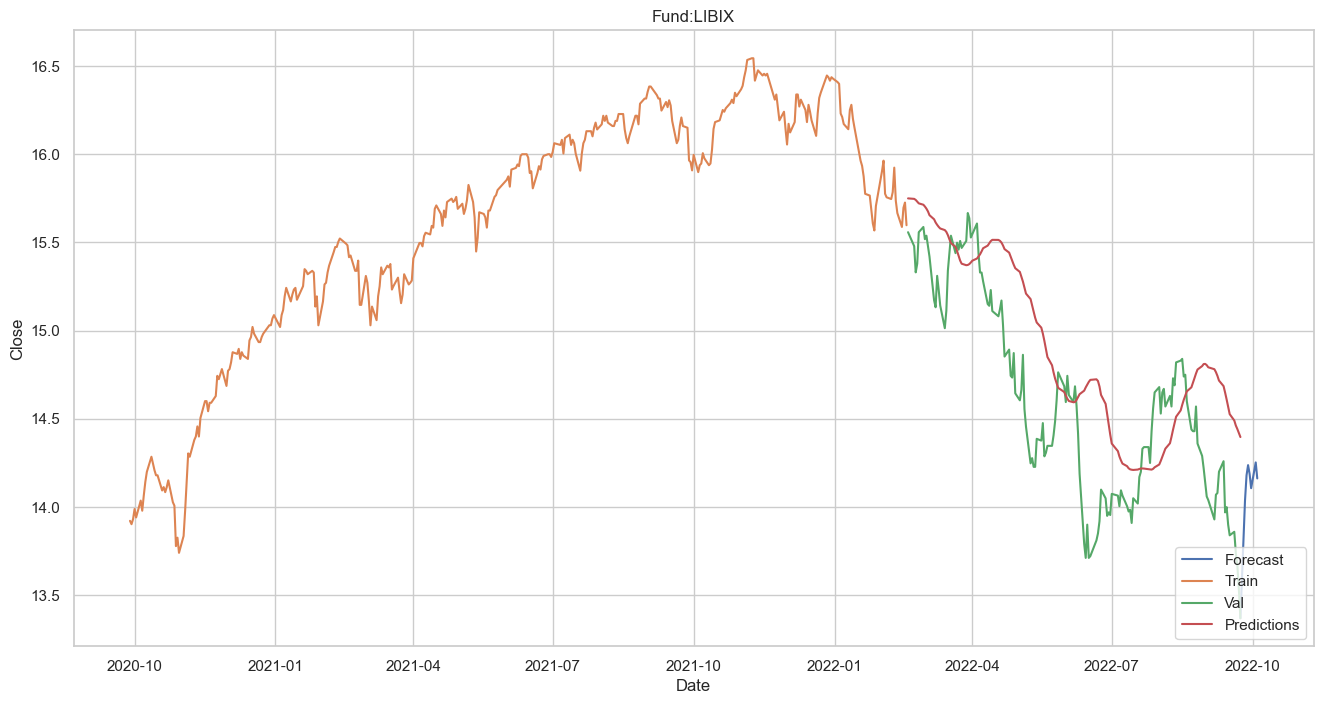

In [11]:
pred = fund_pred(dfall,fundname='LIBIX',n_lookback=60,n_forecast=7,agg=False)

In [12]:
  print(dfall.tail())

            LIBIX      LIHIX  LIJIX  LIKIX  LINIX  LIRIX      LIVIX  LIWIX  \
2022-09-19  13.86  16.920000  15.50  16.18  14.58  12.41  17.790001  11.14   
2022-09-20  13.74  16.709999  15.33  15.99  14.44  12.32  17.549999  11.00   
2022-09-21  13.67  16.480000  15.18  15.80  14.34  12.27  17.280001  10.83   
2022-09-22  13.53  16.330000  15.04  15.65  14.19  12.14  17.139999  10.74   
2022-09-23  13.37  16.000000  14.79  15.36  13.99  12.02  16.760000  10.50   

            LIZKX  PAUAX  ...  FCNTX      FDGRX  ARTMX  VRTGX  SEVAX  FIGFX  \
2022-09-19  15.88   6.69  ...  13.67  25.870001    NaN    NaN    NaN  15.12   
2022-09-20  15.67   6.64  ...  13.53  25.629999    NaN    NaN    NaN  14.84   
2022-09-21  15.43   6.61  ...  13.28  25.150000    NaN    NaN    NaN  14.66   
2022-09-22  15.30   6.53  ...  13.23  24.760000    NaN    NaN    NaN  14.47   
2022-09-23  14.96   6.53  ...  12.99  24.260000    NaN    NaN    NaN  14.14   

            FIVLX BTCFX PTTRX VBIPX  
2022-09-19   7.72 

5/5 [==============================] - 1s 11ms/step
rmse for  FCNTX  is  1.42690547475365
1/1 [==============================] - 0s 21ms/step


C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Predictions'] = predictions[:,-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.loc[:,'Forecast'].iloc[-1] = df_past.loc[:,'Actual'].iloc[-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.app

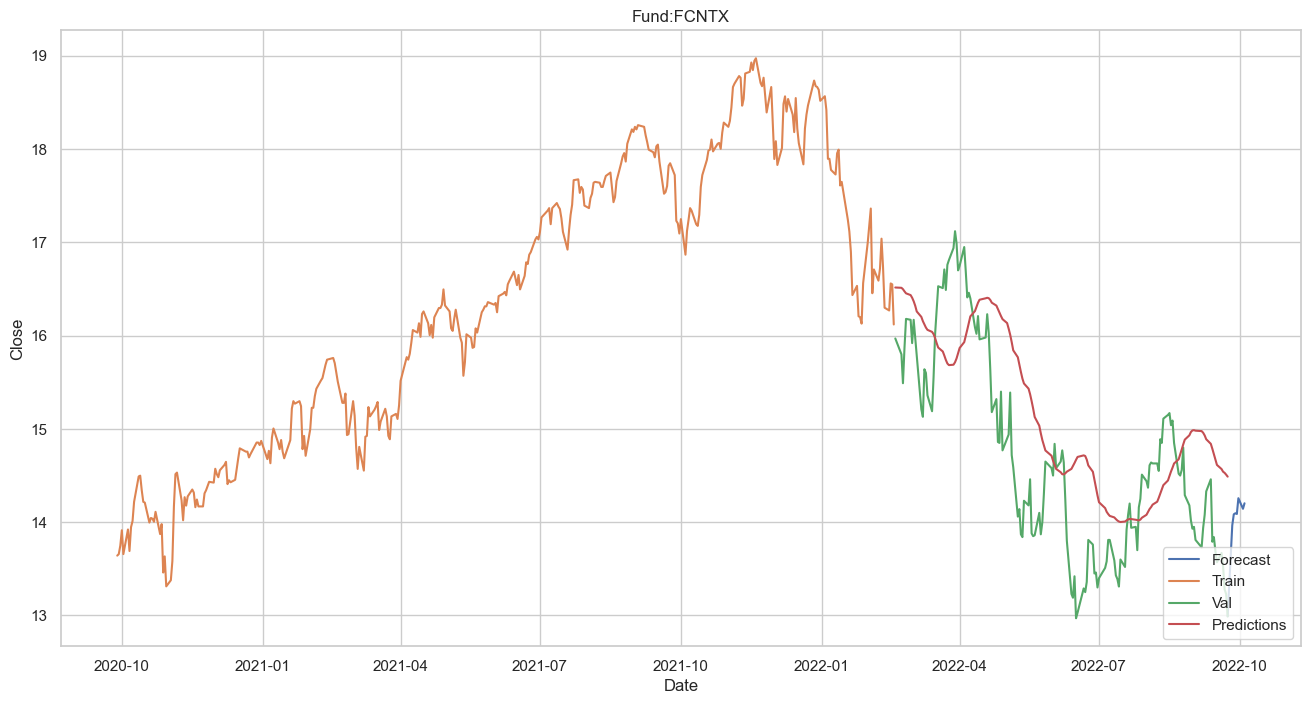

In [13]:
pred = fund_pred(dfall,fundname='FCNTX',n_lookback=60,n_forecast=7,agg=False)

5/5 [==============================] - 1s 10ms/step
rmse for  PTTRX  is  0.7490614121437514
1/1 [==============================] - 0s 20ms/step


C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Predictions'] = predictions[:,-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.loc[:,'Forecast'].iloc[-1] = df_past.loc[:,'Actual'].iloc[-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.app

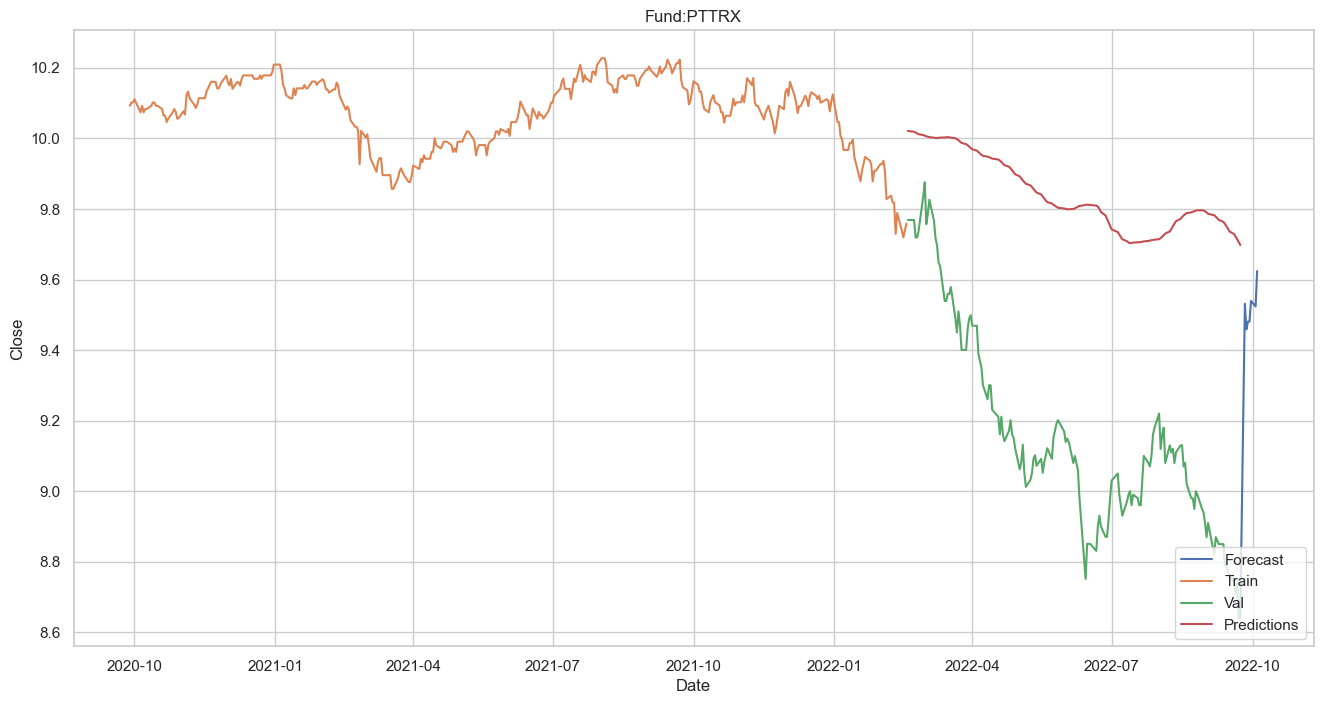

In [14]:
pred = fund_pred(dfall,fundname='PTTRX',n_lookback=60,n_forecast=7,agg=False)

In [15]:
pred.tail(10)

,Actual,Forecast,Name
Date,,,
2022-09-21,8.74,NaN,PTTRX
2022-09-22,8.64,NaN,PTTRX
2022-09-23,8.64,8.640000,PTTRX
2022-09-26,NaN,9.531028,PTTRX
2022-09-27,NaN,9.458896,PTTRX
2022-09-28,NaN,9.480552,PTTRX
2022-09-29,NaN,9.480859,PTTRX
2022-09-30,NaN,9.539316,PTTRX
2022-10-03,NaN,9.523617,PTTRX


5/5 [==============================] - 1s 11ms/step
rmse for  FDGRX  is  3.251441660970883
1/1 [==============================] - 0s 22ms/step


C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Predictions'] = predictions[:,-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.loc[:,'Forecast'].iloc[-1] = df_past.loc[:,'Actual'].iloc[-1]
C:\Users\sunkev\AppData\Local\Temp\ipykernel_7444\1513466193.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.app

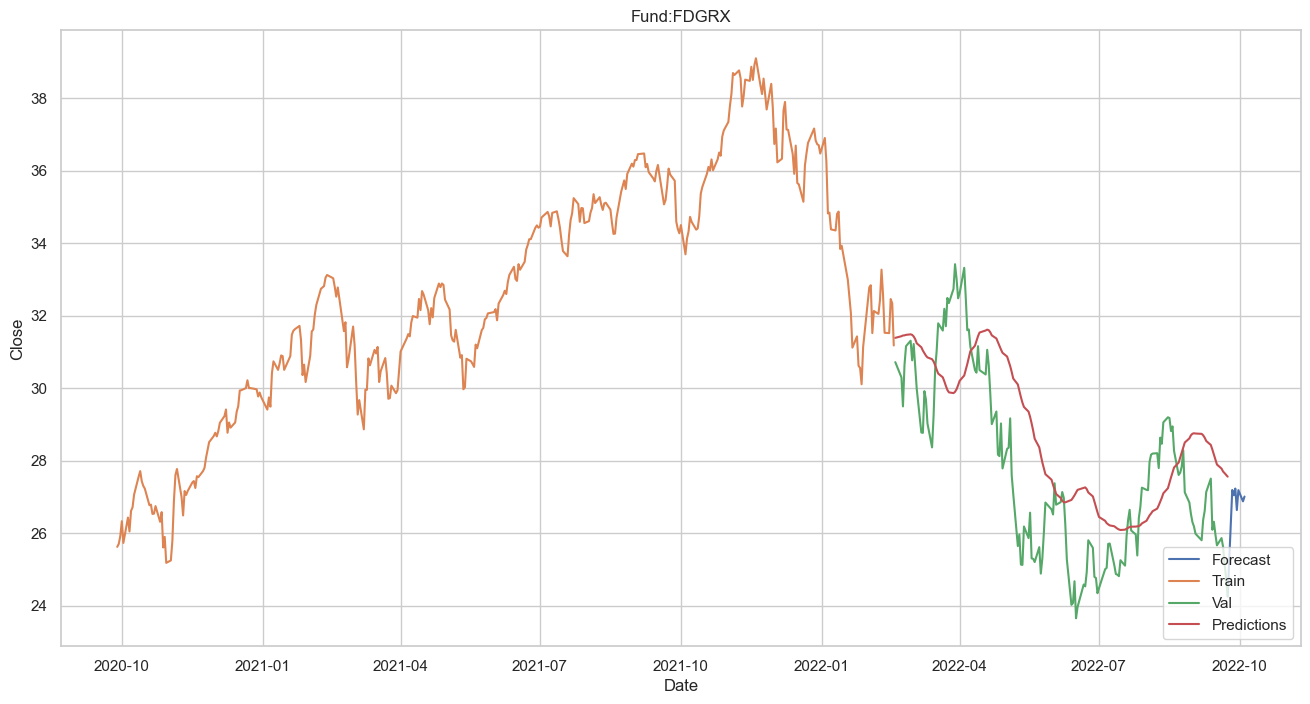

In [16]:
pred = fund_pred(dfall,fundname='FDGRX',n_lookback=60,n_forecast=7,agg=False)

In [17]:
pred.tail(10)

,Actual,Forecast,Name
Date,,,
2022-09-21,25.15,NaN,FDGRX
2022-09-22,24.76,NaN,FDGRX
2022-09-23,24.26,24.260000,FDGRX
2022-09-26,NaN,27.194773,FDGRX
2022-09-27,NaN,27.050049,FDGRX
2022-09-28,NaN,27.234926,FDGRX
2022-09-29,NaN,26.642225,FDGRX
2022-09-30,NaN,27.192453,FDGRX
2022-10-03,NaN,26.883032,FDGRX
